In [1]:
import matplotlib.pyplot as plt #Visulization
from matplotlib import rc # 한글 깨져서
import seaborn as sns #Visulization
import pandas as pd
import numpy as np

import scipy as sp
import scipy.stats

import datetime
from dateutil.relativedelta import relativedelta

import tensorflow as tf

import random
rc('font', family="Malgun Gothic")

#경고 끄기
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
random_seed = random.randrange(1,100000)
tf.set_random_seed(random_seed)

In [3]:
# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

In [4]:
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    # 1e-7은 0으로 나누는 오류 예방차원
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) 

In [5]:
# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [6]:
df = pd.read_csv('cabbage_data.csv')

In [7]:
df['년월'] = df['년월'].apply(lambda x: int(x.replace('-','')))

In [8]:
# 테스트 데이터셋 생성
# 맨 끝의 데이터 삭제함 7월데이터
future_weather = df.iloc[0:-1,:]
future_weather['mm'] = future_weather['년월'].apply(lambda x: str(x)[4:6])
future_weather = pd.DataFrame([future_weather[future_weather['mm'] == '07'].mean().values
                              ,future_weather[future_weather['mm'] == '08'].mean().values
                              ,future_weather[future_weather['mm'] == '09'].mean().values]).iloc[:,1:-2]
future_weather.shape

(3, 50)

In [9]:
# 특정 날짜 인것만
df = df[(199701 <= df['년월']) & (df['년월'] <= 201906)]

In [10]:
# 첫번째 컬럼제거
volume = df.iloc[:,1:-1]

In [11]:
# 부동소수점화
norm_volume = min_max_scaling(volume)
print("volume.shape: ", volume.shape)
# print("volume[0]: ", volume.iloc[0])
# print("norm_volume[0]: ", norm_volume[0])
# print("="*100) # 화면상 구분용

price = df.iloc[:,-1]
price = price.values.reshape(-1,1)

# 부동소수점화
norm_price = min_max_scaling(price)
print("price.shape: ", price.shape)
# print("price[0]: ", price.iloc[0])
# print("norm_price[0]: ", norm_price[0])
# print("="*100) # 화면상 구분용

volume.shape:  (270, 50)
price.shape:  (270, 1)


In [12]:
x = np.append(norm_volume, min_max_scaling(future_weather), axis=0)
y = norm_price

In [13]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용

seq_length = 50            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음달 가격
    dataX.append(_x)
    dataY.append(_y)

In [14]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.9)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(198, 50, 50)
(198, 1)
(22, 50, 50)
(22, 1)


In [15]:
# 하이퍼파라미터
input_data_column_cnt = trainX.shape[2]  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = trainY.shape[1] # 결과데이터의 컬럼 개수
 
rnn_cell_hidden_dim = 10   # 각 셀의 (hidden)출력 크기
forget_bias = 0.8          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 0.9            # dropout할 때 keep할 비율
 
epoch_num = 500           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

In [16]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
Y = tf.placeholder(tf.float32, [None, 1])

In [17]:
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [18]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀 생성
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

In [19]:
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

W0722 16:29:08.034154  4864 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0722 16:29:08.034154  4864 deprecation.py:323] From <ipython-input-18-73d8bf1d5ac9>:5: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [20]:
# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

W0722 16:29:08.045867  4864 deprecation.py:323] From <ipython-input-20-c25db3b61094>:2: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0722 16:29:08.096732  4864 deprecation.py:506] From c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 16:29:08.103715  4864 deprecation.py:506] From c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py:738: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instru

hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 50, 10), dtype=float32)


In [21]:
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 가격을 이용해서 다음날의 가격 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

In [22]:
loss = tf.reduce_sum(tf.square(hypothesis - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [23]:
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [24]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [26]:
print(trainX.shape)
print(trainY.shape)

(198, 50, 50)
(198, 1)


In [27]:
# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, reverse_min_max_scaling(price, train_error), reverse_min_max_scaling(price, test_error), reverse_min_max_scaling(price, test_error-train_error)))

학습을 시작합니다...
epoch: 100, train_error(A): 3906.789941615976, test_error(B): 4518.574693142436, B-A: 2647.169366911075
epoch: 200, train_error(A): 3330.302465834534, test_error(B): 4203.759472517295, B-A: 2908.841622067377
epoch: 300, train_error(A): 3169.712429180194, test_error(B): 4106.362470582104, B-A: 2972.0346567865254
epoch: 400, train_error(A): 2920.8984622734656, test_error(B): 3804.9112314591716, B-A: 2919.3973845703213
epoch: 500, train_error(A): 2933.717311830556, test_error(B): 3760.027875246331, B-A: 2861.6951788003907


In [28]:
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

elapsed_time: 0:00:18.264501
elapsed_time per epoch: 0:00:00.036529


In [29]:
# 하이퍼파라미터 출력
print(random_seed)
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

69196
input_data_column_cnt: 50,output_data_column_cnt: 1,seq_length: 50,rnn_cell_hidden_dim: 10,forget_bias: 0.8,num_stacked_layers: 1,keep_prob: 0.9,epoch_num: 500,learning_rate: 0.01,train_error: 0.04726395,test_error: 0.0907386,min_test_error: 0.0907386


In [30]:
test_predict = sess.run(hypothesis, feed_dict={X: testX})

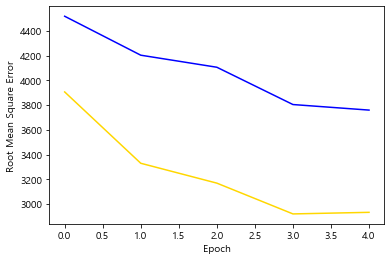

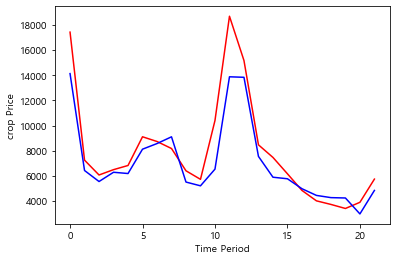

In [31]:
# 결과 그래프 출력
plt.figure(1)
plt.plot(reverse_min_max_scaling(price,train_error_summary), 'gold')
plt.plot(reverse_min_max_scaling(price,test_error_summary), 'b')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error')
 
plt.figure(2)
plt.plot(reverse_min_max_scaling(price,testY), 'r')
plt.plot(reverse_min_max_scaling(price,test_predict), 'b')
plt.xlabel('Time Period')
plt.ylabel('crop Price')
plt.show()

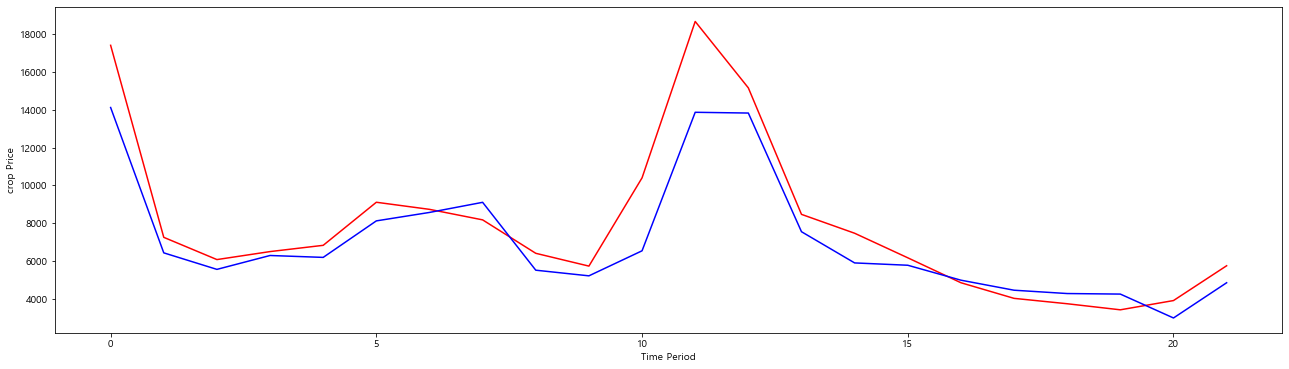

In [32]:
fig, axs = plt.subplots(figsize=(22, 6))
plt.plot(reverse_min_max_scaling(price,testY), 'r')
plt.plot(reverse_min_max_scaling(price,test_predict), 'b')
plt.xlabel('Time Period')
plt.ylabel('crop Price')
plt.show()

In [33]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱
recent_data = np.array([x[len(x)-seq_length-2 : -2], x[len(x)-seq_length-1 : -1], x[len(x)-seq_length : ]])
# print("recent_data.shape:", recent_data.shape)
# print("recent_data:", recent_data)

In [34]:
# 다음달 가격을 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화
print("다음달 예측가격", test_predict[0]) # 예측한 가격을 출력
print("다다음달 예측가격", test_predict[1]) # 예측한 가격을 출력
print("다다다음달 예측가격", test_predict[2]) # 예측한 가격을 출력

다음달 예측가격 [8392.183]
다다음달 예측가격 [9035.641]
다다다음달 예측가격 [5976.9155]
